# 필요 package

In [52]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.style.use('ggplot')

import os
import warnings
warnings.filterwarnings(action='ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.width', 1000)

from selenium import webdriver as wd
import time
from bs4 import BeautifulSoup
import requests
import re

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import font_manager, rc
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import style

# 크롤링 코드

In [ ]:
browser = wd.Chrome("../../software/chromedriver.exe")
browser.get("https://www.airport.co.kr/jeju/extra/flightSchedule/flightDomesticList/layOut.do?cid=2015120718125215729&menuId=653")

element = browser.find_element_by_xpath('//*[@id="selType"]')
element.click()

element = browser.find_element_by_xpath('//*[@id="selType"]/option[2]')
element.click()

element = browser.find_element_by_xpath('//*[@id="findDate"]')
element.clear()
element.send_keys("2019-10-27")

element = browser.find_element_by_xpath('//*[@id="customer_container"]/div[2]/form/div/div[2]/button')
element.click()

air_head = []

element = browser.find_element_by_xpath('//*[@id="customer_container"]/div[3]/table/thead')

for i in range(1, 264):
    temp = []
    for j in range(1, 9):  
        element = browser.find_element_by_xpath('//*[@id="customer_container"]/div[3]/table/tbody[1]/tr[{0}]/td[{1}]'.format(i, j))
        temp.append(element.text)
    air_content.append(temp)
    
for i in range(1, 272):
    temp = []
    for j in range(1, 9):  
        element = browser.find_element_by_xpath('//*[@id="customer_container"]/div[4]/table/tbody[1]/tr[{0}]/td[{1}]'.format(i, j))
        temp.append(element.text)
    air_content.append(temp)
    
test = pd.DataFrame(data = air_content, columns = air_head)

test["제주 관련 시간"] = 0
test["제주 시간 관련"] = 0

for i in range(len(test)):
    if test["출발지"][i] == "제주":
        test["제주 관련 시간"][i] = test["출발시간"][i]
    else:
        test["제주 관련 시간"][i] = test["도착시간"][i]
        
test.drop("편명", axis = 1, inplace = True)

test.to_csv("../data/result_air.csv")

# 데이터 불러오기

In [53]:
# 데이터 불러오기
bus_df = pd.read_csv("bus_train_data.csv")
weather_df = pd.read_csv("jeju_weather.csv")
air_df = pd.read_csv("result_air.csv")

In [54]:
weather_df["date"] = "date"

In [55]:
for i in range(len(weather_df["date_group"])):
    weather_df["date"][i] = weather_df["date_group"][i].replace("일", "")
    weather_df["date"][i] = "2019-10-{0}".format(weather_df["date"][i])
    
weather_df = weather_df.rename(columns = {"time_group" : "now_arrive_time"})
weather_df = weather_df.drop(weather_df.columns[[0,2,5,7,8,9,10,11]],  axis = 1)

bus_weather_df = pd.merge(bus_df, weather_df)

In [56]:
temp = air_df.groupby(["날짜", "시간"]).count()
temp = pd.DataFrame(temp["항공사"].unstack())

data_list = []

for i in range(len(temp.index)):
    for j in range(len(temp.columns)):
        data_list.append([temp.index[i],temp.columns[j], temp.iloc[i][j]])
        
air_df = pd.DataFrame(data_list)

air_df.columns = ["date", "now_arrive_time", "count"]

df = pd.merge(bus_weather_df, air_df)

train = df

In [57]:
# 날짜 전처리
train['date_group']='weekday' #date_group 변수를 미리 생성

train.loc[ (train['date'] == '2019-10-19') | (train['date'] == '2019-10-20') | (train['date'] == '2019-10-26') | (train['date'] == '2019-10-27') ,['date_group'] ]= 'weekend' # 주말
train = pd.get_dummies(train,columns=['date_group'])

# 19, 20, 26, 27

In [58]:
# 강수량 전처리
train['rain']=0
train.loc[ (train['누적강수량(mm)']!=0) ,['rain'] ] = 1

In [59]:
# 시간 전처리
train['time_group']='group' #time_group 변수를 미리 생성

train.loc[ (train['now_arrive_time']>='05시') & (train['now_arrive_time']<='06시') ,['time_group'] ]= 'dawn' # 05~06시
train.loc[ (train['now_arrive_time']>='07시') & (train['now_arrive_time']<='08시') ,['time_group'] ]= 'morning' #07~08시
train.loc[ (train['now_arrive_time']>='09시') & (train['now_arrive_time']<='17시') ,['time_group'] ]= 'afternoon' #09~17시
train.loc[ (train['now_arrive_time']=='18시') ,['time_group'] ]= 'dinner' #18시
train.loc[ (train['now_arrive_time']>='19시') & (train['now_arrive_time']<='22시') ,['time_group'] ]= 'night' #09~17시

train = pd.get_dummies(train,columns=['time_group'])

In [60]:
# 풍속
w = pd.DataFrame(train['풍속(m/s)'].groupby([train['date'],train['now_arrive_time']]).mean())
train['wind'] = 0
train.loc[(train['풍속(m/s)'] > w.mean()[0]) ,['wind']] = 1

In [61]:
train = train.drop(train[train['next_arrive_time']>1000].index)

In [62]:
train = train.drop(train[["누적강수량(mm)", "풍속(m/s)"]], axis = "columns")

In [63]:
train

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time,기온(°C),count,date_group_weekday,date_group_weekend,rain,time_group_afternoon,time_group_dawn,time_group_dinner,time_group_morning,time_group_night,wind
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,06시,266.0,제대마을,33.457724,126.554014,24,15.526667,3,1,0,0,0,1,0,0,0,0
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,06시,333.0,제대아파트,33.458783,126.557353,36,15.526667,3,1,0,0,0,1,0,0,0,0
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,06시,415.0,제주대학교,33.459893,126.561624,40,15.526667,3,1,0,0,0,1,0,0,0,0
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42,15.526667,3,1,0,0,0,1,0,0,0,0
4,181,2019-10-15,405136001,7997034,360-1,33.484860,126.542928,제주여자중고등학교(아라방면),06시,578.0,남국원(아라방면),33.479705,126.543811,92,15.526667,3,1,0,0,0,1,0,0,0,0
5,182,2019-10-15,405136001,7997034,360-1,33.473655,126.545425,아라주공아파트,06시,244.0,인다마을,33.471450,126.545400,20,15.526667,3,1,0,0,0,1,0,0,0,0
6,183,2019-10-15,405136001,7997034,360-1,33.458783,126.557353,제대아파트,06시,415.0,제주대학교,33.459893,126.561624,36,15.526667,3,1,0,0,0,1,0,0,0,0
7,184,2019-10-15,405136001,7997034,360-1,33.479705,126.543811,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,84,15.526667,3,1,0,0,0,1,0,0,0,0
8,539,2019-10-15,405136001,7997040,360-1,33.478867,126.483833,한라중학교/부영아파트,06시,417.0,대림2차아파트,33.478850,126.488350,158,15.526667,3,1,0,0,0,1,0,0,0,0
9,540,2019-10-15,405136001,7997040,360-1,33.478850,126.488350,대림2차아파트,06시,334.0,연동대림1차아파트,33.480700,126.489933,54,15.526667,3,1,0,0,0,1,0,0,0,0


In [75]:
train_x = train.drop(train[["id", "date","route_id", "vh_id", "route_nm", "now_latitude", "now_longitude", "now_station", "now_arrive_time", "next_station", "next_arrive_time", "next_latitude", "next_longitude"]], axis = "columns")
train_y = train.next_arrive_time
train_x

,distance,기온(°C),count,date_group_weekday,date_group_weekend,rain,time_group_afternoon,time_group_dawn,time_group_dinner,time_group_morning,time_group_night,wind
0,266.0,15.526667,3,1,0,0,0,1,0,0,0,0
1,333.0,15.526667,3,1,0,0,0,1,0,0,0,0
2,415.0,15.526667,3,1,0,0,0,1,0,0,0,0
3,578.0,15.526667,3,1,0,0,0,1,0,0,0,0
4,578.0,15.526667,3,1,0,0,0,1,0,0,0,0
5,244.0,15.526667,3,1,0,0,0,1,0,0,0,0
6,415.0,15.526667,3,1,0,0,0,1,0,0,0,0
7,578.0,15.526667,3,1,0,0,0,1,0,0,0,0
8,417.0,15.526667,3,1,0,0,0,1,0,0,0,0
9,334.0,15.526667,3,1,0,0,0,1,0,0,0,0


In [68]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y)

In [69]:
rf = RandomForestRegressor(random_state=1217)
rf.fit(X_train,y_train)
result = 0
predict = rf.predict(X_test)
print((mean_squared_error(predict, y_test))**0.5)

46.2079283253166


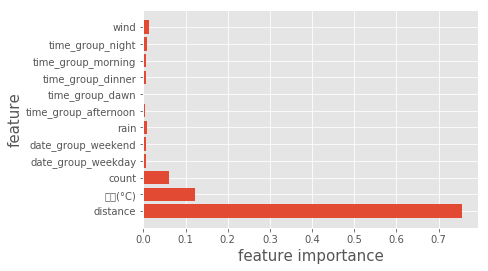

In [70]:
n_feature = train_x.shape[1] #주어진 변수들의 갯수를 구함
index = np.arange(n_feature)

input_var= list( train_x.columns[:] )
plt.barh(index, rf.feature_importances_, align='center') 
plt.yticks(index, input_var)
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

In [71]:
input_var

['distance',
 '기온(°C)',
 'count',
 'date_group_weekday',
 'date_group_weekend',
 'rain',
 'time_group_afternoon',
 'time_group_dawn',
 'time_group_dinner',
 'time_group_morning',
 'time_group_night',
 'wind']

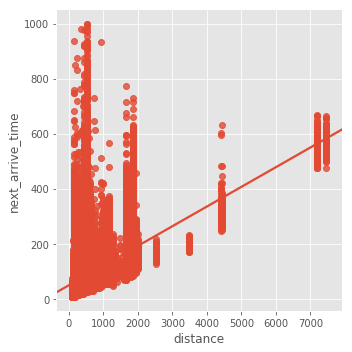

In [45]:
sns.lmplot(x='distance', y='next_arrive_time', data=train)

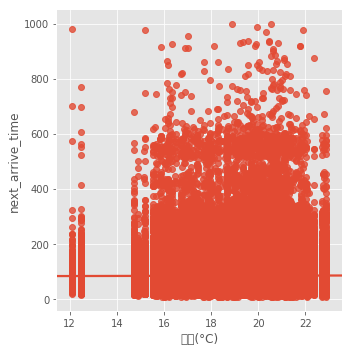

In [46]:
sns.lmplot(x='기온(°C)', y='next_arrive_time', data=train)

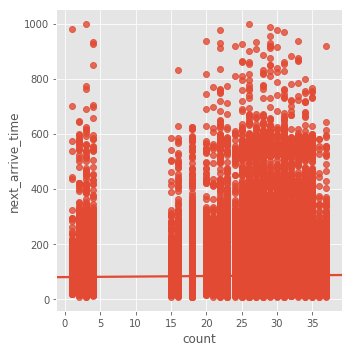

In [47]:
sns.lmplot(x='count', y='next_arrive_time', data=train)

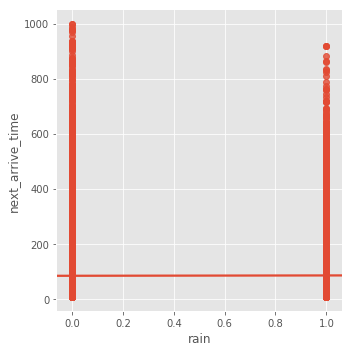

In [48]:
sns.lmplot(x='rain', y='next_arrive_time', data=train)

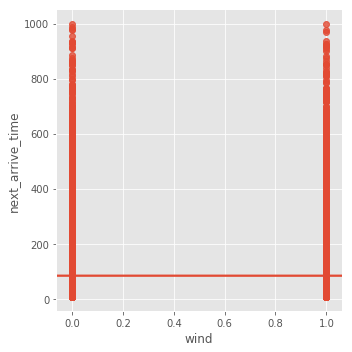

In [49]:
sns.lmplot(x='wind', y='next_arrive_time', data=train)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 9999):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_test)
    val_error = mean_squared_error(y_test, y_pred)
    print((val_error)**0.5)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # 조기 종료

62.625824800145686
60.84572936090168
59.36211236768432
58.1330079341659
57.10931702790881
56.26273819956207
55.53173600476099
54.935459617559665
54.424222990713254
54.01142147349637
53.65257889523728
53.35157823950338
53.0637926459678
52.821878649245285
52.630831677279126
52.459917304227446
52.2568322788977
52.08133922603858
51.96788938459902
51.87561009268175
51.78627158029236
51.716173126947176
51.6530388424558
51.59366090918558
51.54342842046924
51.44127726517191
51.29478662019341
51.253377228123234
51.208842799605
51.09021267254596
51.00989682329127
50.97520368149721
50.8248386102498
50.78839171640395
50.760042452987186
50.69831766005913
50.64471651301937
50.61321087320979
50.51642268153495
50.48015230904404
50.38726775979166
50.29744780662373
50.27465012083626
50.23708975264965
50.20993906519885
50.161537899123275
50.14102129508744
50.064984507780984
50.029501452593564
49.987985695395345
49.91574449858154
49.89841686635753
49.87958837509292
49.76020051889164
49.74965631312109
49.6

44.10133623872387
44.101107802590775
44.09993789767329
44.09953713323723
44.099076666567335
44.09910622449903
44.09897042627999
44.093999520437734
44.083660837180375
44.0791954685837
44.07266264709828
44.065652574789354
44.0601259831595
44.041237910296346
44.03203183668
44.01611912933448
44.00325482870591
43.996624317874954
43.99020575645403
43.98464459569513
43.979139385764014
43.97070755788379
43.94844113940453
43.94406308469776
43.933924319711466
43.912624431265726
43.9071469188598
43.89539001556101
43.88857004029476
43.88348736517337
43.877690204206836
43.87419676236922
43.87035555247038
43.8665676720555
43.86235285793704
43.855123318402505
43.85299793723545
43.85142353474253
43.85056600271695
43.84610733255546
43.84092789539606
43.83704831705613
43.836760400695646
43.83632748182374
43.8354337129053
43.83531927217678
43.830558373335364
43.82851091463198
43.82574183755308
43.821793977914396
43.81787008961025
43.81483474979654
43.81464411811078
43.8122335068186
43.80932461861332
43.8